# Example calculation of PV potential for ERA5 data

I calculate for one year and derive monthly-mean values of PV potential. I compare two manners of parallelizing the work:

1. multiprocessing with 1 process per file, hence 12 processes; each process uses dask-xarray under the hood and can hence use >100% CPU
2. dask-xarray processing of 1 dataset with all 12 months

In [7]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from multiprocessing import Process, Queue

import core as core

import warnings
warnings.filterwarnings("ignore")

In [8]:
# location of era5 data on teachinghub
path="~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

## 1. Multiprocessing

In [9]:
# generate list of era5 files for a given year
def get_filelists(years: str):
    flist = list()
    for file in Path(path).rglob("era5-"+year+"-*.nc"):
        flist.append(file)
    return flist

In [10]:
# function to compute time-mean pv potential, will be called by multiprocessing
def batchcompute_pvpot(file, queue):
    ds = xr.open_dataset(file, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)
    pv_pot = core.pv_pot(ds).mean("valid_time").compute()
    queue.put(pv_pot)
    return None

In [11]:
nlat = 721;
nlon = 1440;

def multi_processing():
    years= ["1950","1951"]
    flist = []
    for year in years:
        flist.extend(get_filelists(year))
    print("flist", flist)
    # use 1 process per monthly file
    nprocs = len(flist)
    # output from each process
    pvpot_chk = np.zeros((nprocs,nlat,nlon))
    queue = Queue()
    processes = [Process(target=batchcompute_pvpot, 
                         args=(flist[i], queue)) for i in range(0, nprocs)]
    for process in processes: process.start() # start all processes
    for i in range(nprocs): # collect results from processes
        pvpot_chk[i] = queue.get()
    for process in processes: process.join()  # wait for all processes to complete
    # merge into yearly array
    pvpot = np.stack(pvpot_chk, axis=0)

In [6]:
multi_processing()

NameError: name 'year' is not defined

In [ ]:
#core.measure_performance(multi_processing)

## 2. Dask-array on merged file

In [8]:
def dask_xarray():
    ds2=xr.open_mfdataset(path+"era5-2000-*.nc", chunks={"valid_time":1e5} )
    ds2["wspd"] = core.windspeed(ds2)
    pvpot2 = core.pv_pot(ds2).groupby(ds2.valid_time.dt.month).mean("valid_time").compute()

In [9]:
core.measure_performance(dask_xarray)

Execution time: 841.82140 seconds


/lehre/msc-intro-comp-met-ex-w2024/data/era5


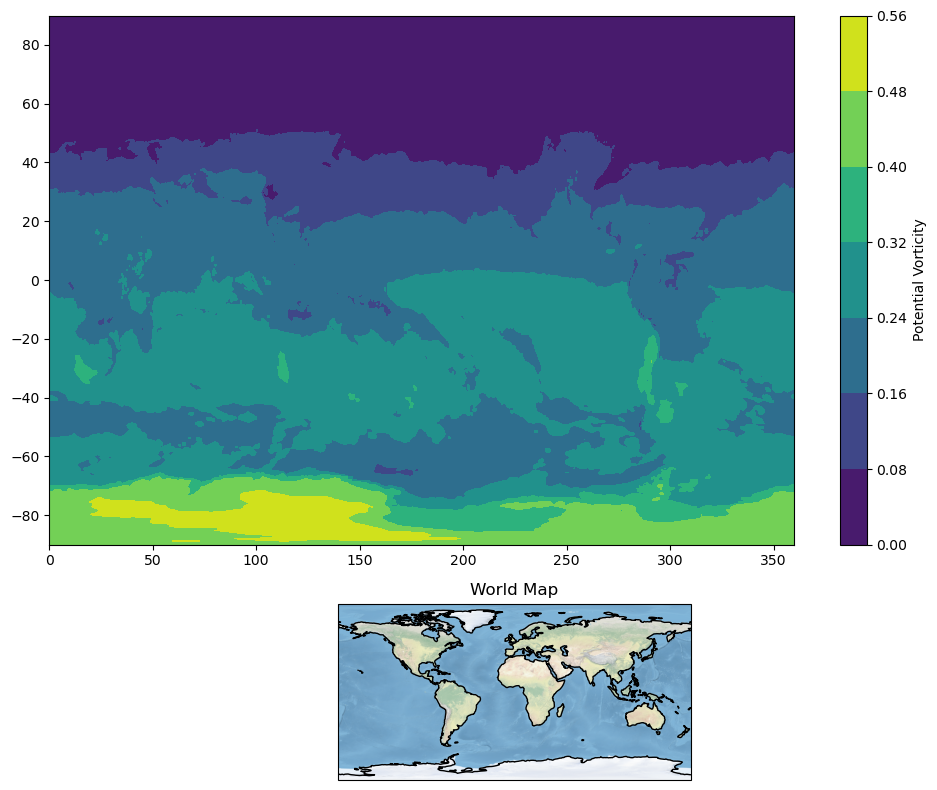

In [12]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from multiprocessing import Process, Queue
import cartopy.crs as ccrs
import core as core

import warnings
warnings.filterwarnings("ignore")

# location of era5 data on teachinghub
path="../../LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"
print(Path(path).resolve())

years= ["1950"]

"""# generate list of era5 files for a given year
def get_filelists(year: str):
    flist = list()
    for file in Path(path).rglob("era5-"+str(year)+"-01.nc"):
        flist.append(file)
    return flist

# function to compute time-mean pv potential, will be called by multiprocessing
def batchcompute_pvpot(file, queue):
    ds = xr.open_dataset(file, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)
    pv_pot = core.pv_pot(ds).mean("valid_time").compute()
    queue.put(pv_pot)
    return None


nlat = 721;
nlon = 1440;
"""
"""def multi_processing(years):
    filelists = []
    for year in years:
        filelists.append(get_filelists(year))
    for flist in filelists:
        #print(flist)
        # use 1 process per monthly file
        nprocs = len(flist)
        # output from each process
        pvpot_chk = np.zeros((nprocs,nlat,nlon))
        queue = Queue()
        processes = [Process(target=batchcompute_pvpot, 
                            args=(flist[i], queue)) for i in range(0, nprocs)]
        for process in processes: process.start() # start all processes
        for i in range(nprocs): # collect results from processes
            pvpot_chk[i] = queue.get()
        for process in processes: process.join()  # wait for all processes to complete
            #        # merge into yearly array
       # pvpot = np.stack(pvpot_chk, axis=0)
       # print(pvpot) 
"""

ds2=xr.open_mfdataset(path+"era5-1950-01.nc", chunks={"valid_time":1e5} )
ds2["wspd"] = core.windspeed(ds2)
pvpot2 = core.pv_pot(ds2).groupby(ds2.valid_time.dt.month).mean("valid_time").compute()

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])  # two rows, one for each plot

# First subplot: Contour plot
ax1 = fig.add_subplot(gs[0, 0])
contour = ax1.contourf(ds2.longitude, ds2.latitude, pvpot2[0, :, :])  # Plot first month for example
fig.colorbar(contour, ax=ax1, orientation="vertical", label="Potential Vorticity")  # Add colorbar

# Second subplot: World map
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax2.set_global()
ax2.stock_img()  # Background world image
ax2.coastlines()
ax2.set_title("World Map")

plt.tight_layout()
plt.show()